In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
from tifffile import imshow, imsave
from tqdm import tqdm
import matplotlib.pyplot as plt
from time import time

In [2]:
def parse_image(path, all_channels_last=False):
  im = np.load(path)
  img = im['arr_0']
  if all_channels_last:
    img = np.moveaxis(img, 0, 2)
    img = img.reshape(img.shape[0], img.shape[1], -1)
  return img

In [3]:
def check_intersection(img):
    mask = np.ones((955,955,3), dtype=np.bool)
    for i in range(len(img)):
        msk = img[i] == 0
        mask = mask * msk
    print(np.count_nonzero(mask))

In [4]:
path = 'D:/Docs/Visillect/agrofields/adc/restoration/data/Clean_Data/input/L8_18.npz'

img = parse_image(path)

In [5]:
img = img[:,:,:,0]

In [6]:
from catboost import Pool, CatBoostRegressor
from skimage.morphology import dilation, disk

In [7]:
def create_train_data(target_image, target_mask, train_mask, j, window_size):
    target_image_window = target_image[:, j: j + window_size]
    target_mask_window = target_mask[:, j: j + window_size]
    if np.count_nonzero(target_mask_window) == 0:
        return 0, 0, 0, 0, 0
    train_mask_window = train_mask[:, j: j + window_size]
    training_images_window = training_images[:, :, j: j + window_size]
    train_data = np.array([training_images_window[m][train_mask_window] for m in range(len(training_images_window))])
    train_label = target_image_window[train_mask_window]
    train_data = np.moveaxis(train_data, 0, 1)
    mask_to_fill = train_data == 0
    train_data[mask_to_fill] = None
    restore_data = np.array([training_images_window[m][target_mask_window] for m in range(len(training_images_window))])
    restore_data = np.moveaxis(restore_data, 0, 1)
    mask_to_fill = restore_data == 0
    restore_data[mask_to_fill] = None
    return train_data, train_label, restore_data, target_mask_window, target_image_window


In [8]:
window_size = 96
threshold = img.shape[1] - window_size

for target_image_number in range(4, -1, -1):

    target_image = img[target_image_number]
    training_images = np.concatenate([img[:target_image_number], img[target_image_number+1:]], axis=0)
    target_mask = target_image == 0
    train_mask = dilation(target_mask, disk(10))
    # train_mask = train_mask ^ target_mask
    restore_indexes = np.where(train_mask)
    indexes = np.moveaxis(np.array(restore_indexes), 0, 1)
    labels = DBSCAN(eps=1.5).fit_predict(indexes)
    train_masks = []
    target_masks = []
    for i in set(labels):
        ind = np.where(labels == i)
        train_mask_2 = np.zeros(shape=train_mask.shape, dtype=np.bool)
        rst = tuple((restore_indexes[0][ind], restore_indexes[1][ind]))
        train_mask_2[rst] = True
        target_masks.append(train_mask_2 * target_mask)
        train_masks.append(train_mask_2 ^ target_masks[-1])
    # print(len(set(labels)))
    # break
    # train_mask = target_image != 0
    # noinspection PyUnreachableCode
    for j in tqdm(range(0, img.shape[-1], window_size)):
        for train_mask_current, target_mask_current in zip(train_masks, target_masks):
            if j > threshold:
                j = threshold

            train_data, train_label, restore_data, target_mask_window, target_image_window = create_train_data(target_image,
                                                                                                               target_mask_current,
                                                                                                               train_mask_current,
                                                                                                               j, window_size)
            if type(train_data) == int:
                continue
            train_pool = Pool(train_data, train_label)

            # tick = time()
            model = CatBoostRegressor(
                depth=5,
                learning_rate=0.2,
                loss_function='RMSE',
                verbose=0, num_trees=40
            )
            model.fit(train_pool)
            # tack = time()
            # print((tack - tick) * 1000)
            # break
            restore_pool = Pool(restore_data)
            res = model.predict(restore_pool)
            target_image_window[target_mask_window] = res
            img[target_image_number, :, j: j + window_size] = target_image_window
        # break
    img[target_image_number] = np.clip(img[target_image_number], 0, 1)


100%|██████████| 10/10 [01:04<00:00,  6.46s/it]


In [15]:
path = 'D:/Docs/Visillect/agrofields/adc/restoration/data/Clean_Data/output/L8_18.npz'

img2 = parse_image(path)
img2 = img2[:,:,:,0]

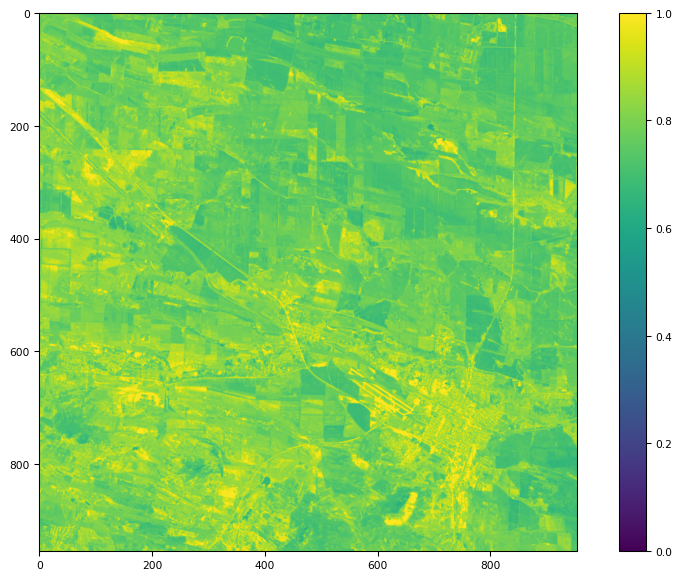

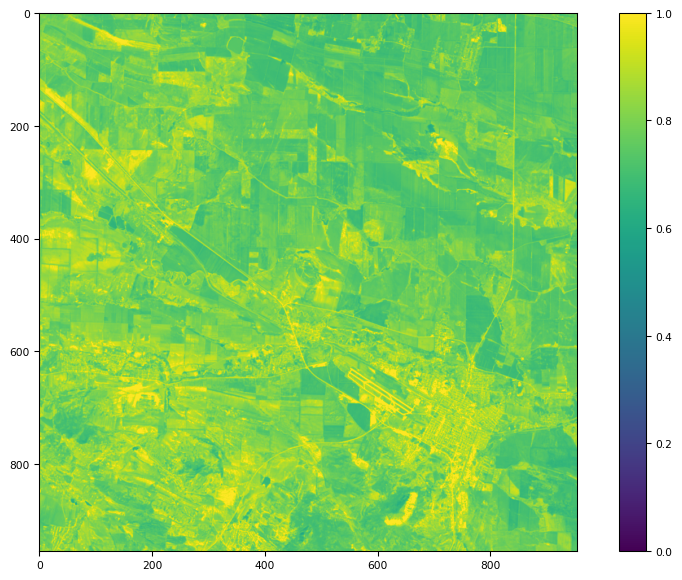

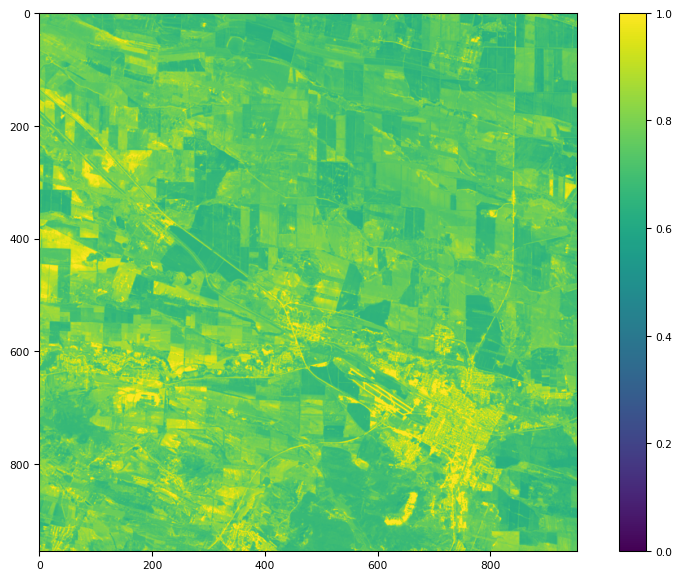

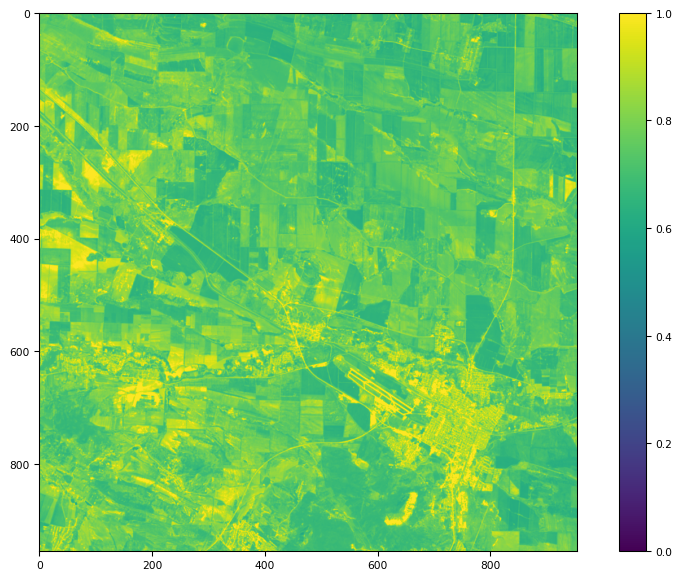

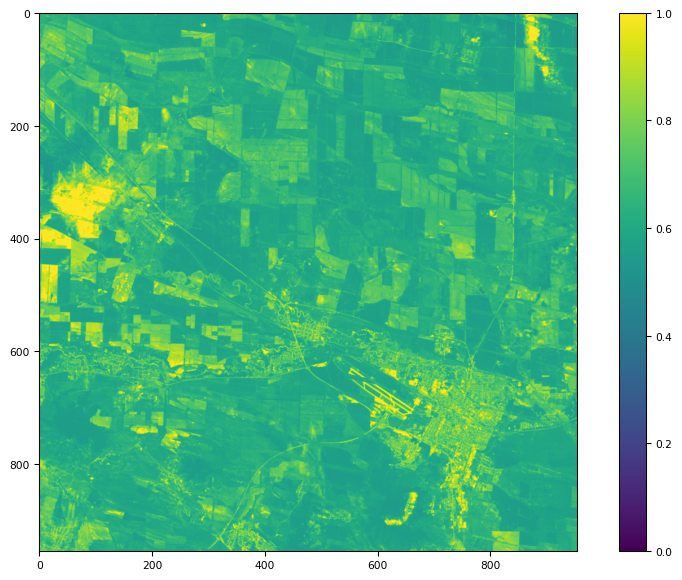

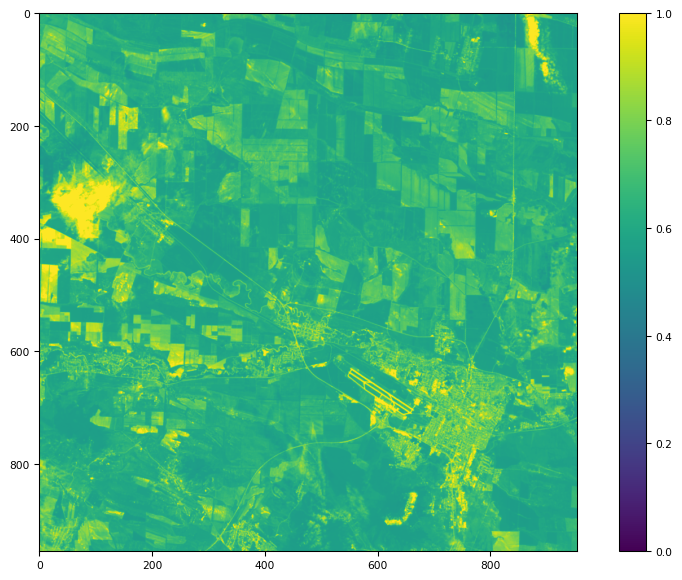

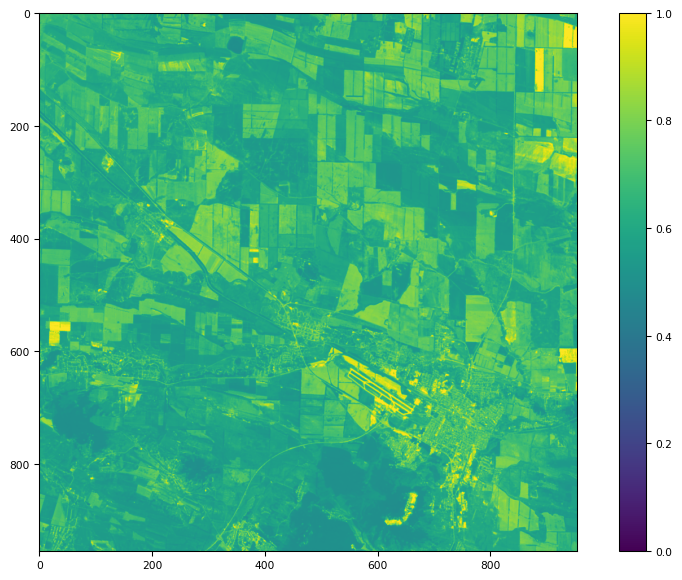

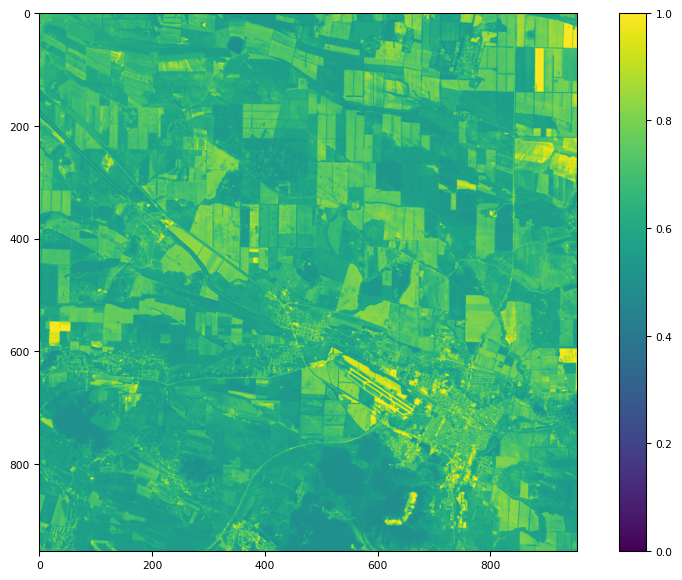

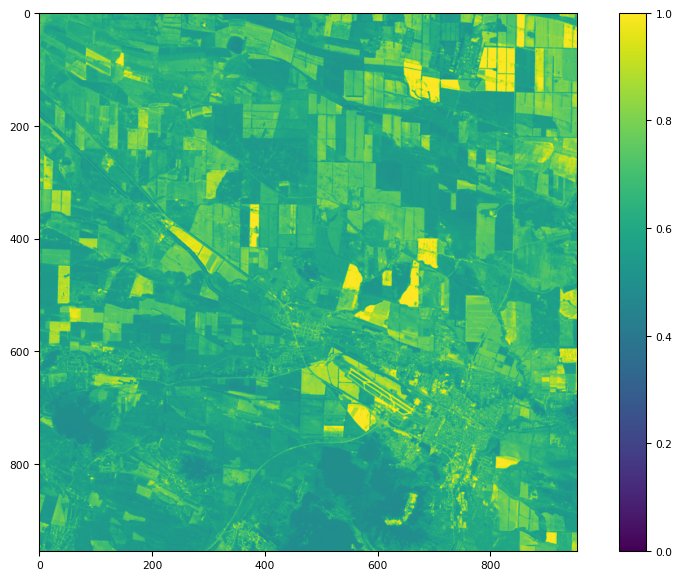

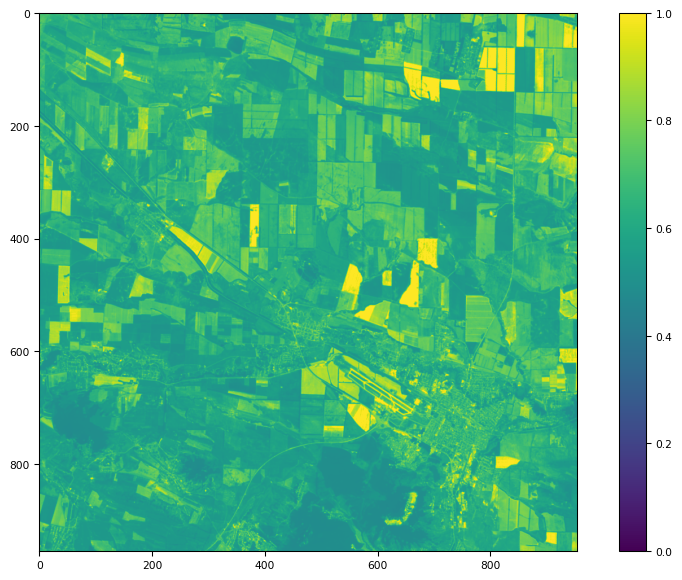

In [10]:
for i in range(len(img)):
    imshow(img[i], vmax=1, vmin=0)
    imshow(img2[i], vmax=1, vmin=0)

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [12]:
for target_image_number in range(5):
    print(mean_absolute_error(img2[target_image_number, :, :, 0].reshape(-1), img[target_image_number].reshape(-1)))
    # print(mean_squared_error(img2[target_image_number, :, :, 0].reshape(-1), img[target_image_number].reshape(-1)) ** (1 / 2))
    imsave('res{}.tif'.format(target_image_number), img[target_image_number])


0.008592973878104971
0.008252337294066625
0.006787127432216888
0.004648424746304974
0.0056047719728877805
